# A Machine Learning Approach to Visual Perception of Corridor Trails for Mobile Robots

@Author: Artur Leinweber <br>
@E-Mail: arturleinweber@live.de <br>
@University: Westphalian University of Gelsenkirchen <br>

### Imports
tf.keras is TensorFlow's implementation of the Keras API specification. This is a high-level API to build and train models that includes first-class support for TensorFlow-specific functionality.
Importing tf.keras makes TensorFlow easier to use without sacrificing flexibility and performance.


In [1]:
%matplotlib inline  
import tensorflow as tf
from tensorflow.keras import layers, regularizers, utils, preprocessing, optimizers, backend
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import time
import os
import cv2
import sys

print("Tensorflow Version: " + tf.VERSION)
print("Keras Version: " + tf.keras.__version__)
tf.logging.set_verbosity(tf.logging.ERROR)

Tensorflow Version: 1.13.1
Keras Version: 2.2.4-tf


Progressbar function

In [2]:
def update_progress(progress, custom=""):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = custom + "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text, end="\r")

### Sequential model
In Keras, you assemble layers to build models. A model is (usually) a graph of layers. The most common type of model is a stack of layers: the tf.keras.Sequential model.

In [3]:
# Layer 1
Conv2DLayer1 = layers.Conv2D(input_shape = (101,101,3),
                             filters = 32,
                             kernel_size = (4,4),
                             padding = "valid",
                             strides = (1, 1),
                             kernel_initializer = "glorot_uniform",
                             kernel_regularizer = regularizers.l2(0.0005)) 

ActivationLayer1 = layers.Activation("tanh")

NormalizationLayer1 = layers.BatchNormalization()

PoolingLayer1 = layers.MaxPooling2D(pool_size = (2, 2),
                                    strides = (2, 2),
                                    padding = "valid")

# Layer 2
Conv2DLayer2 = layers.Conv2D(filters = 32,
                             kernel_size = (4,4),
                             padding = "valid",
                             strides = (1, 1),
                             kernel_initializer = "glorot_uniform",
                             kernel_regularizer = regularizers.l2(0.0005))

ActivationLayer2 = layers.Activation("tanh")

NormalizationLayer2 = layers.BatchNormalization()

PoolingLayer2 = layers.MaxPooling2D(pool_size = (2, 2),
                                    strides = (2, 2),
                                    padding = "valid")
# Layer 3
Conv2DLayer3 = layers.Conv2D(filters = 32,
                             kernel_size = (4,4),
                             padding = "valid",
                             strides = (1, 1),
                             kernel_initializer = "glorot_uniform",
                             kernel_regularizer = regularizers.l2(0.0005))

ActivationLayer3 = layers.Activation("tanh")

NormalizationLayer3 = layers.BatchNormalization()

PoolingLayer3 = layers.MaxPooling2D(pool_size = (2, 2),
                                    strides = (2, 2),
                                    padding = "valid")
# Layer 4
Conv2DLayer4 = layers.Conv2D(filters = 32,
                             kernel_size = (3,3),
                             padding = "valid",
                             strides = (1, 1),
                             kernel_initializer = "glorot_uniform",
                             kernel_regularizer = regularizers.l2(0.0005))

ActivationLayer4 = layers.Activation("tanh")

NormalizationLayer4 = layers.BatchNormalization()

PoolingLayer4 = layers.MaxPooling2D(pool_size = (2, 2),
                                    strides = (2, 2),
                                    padding = "valid")
# Fully Connected Layer
FlattenLayer5 = layers.Flatten()
#DenseLayer5 = layers.Dense(200, kernel_initializer = "glorot_uniform")
DenseLayer5 = layers.Dense(130, kernel_initializer = "glorot_uniform")
ActivationLayer5 = layers.Activation("tanh")
NormalizationLayer5 = layers.BatchNormalization()

# Softmax Classifier
DenseLayer6 = layers.Dense(3)
ActivationLayer6 = layers.Activation("softmax")

model_architecture = [
         Conv2DLayer1,
         ActivationLayer1,
         NormalizationLayer1,
         PoolingLayer1,
         
         Conv2DLayer2,
         ActivationLayer2,
         NormalizationLayer2,
         PoolingLayer2,
         
#         Conv2DLayer3,
#         ActivationLayer3,
#         NormalizationLayer3,
#         PoolingLayer3,
         
#         Conv2DLayer4,
#         ActivationLayer4,
#         NormalizationLayer4,
#         PoolingLayer4,
         
         FlattenLayer5,
         DenseLayer5,
         ActivationLayer5,
         NormalizationLayer5,
         
         DenseLayer6,
         ActivationLayer6]

model = tf.keras.Sequential(model_architecture)

### Prints a summary representation of the model

In [4]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        1568      
_________________________________________________________________
activation (Activation)      (None, 98, 98, 32)        0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 32)        16416     
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 32)        0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 46, 46, 32)        128       
__________

### Plot a graph of the model and save it to a file

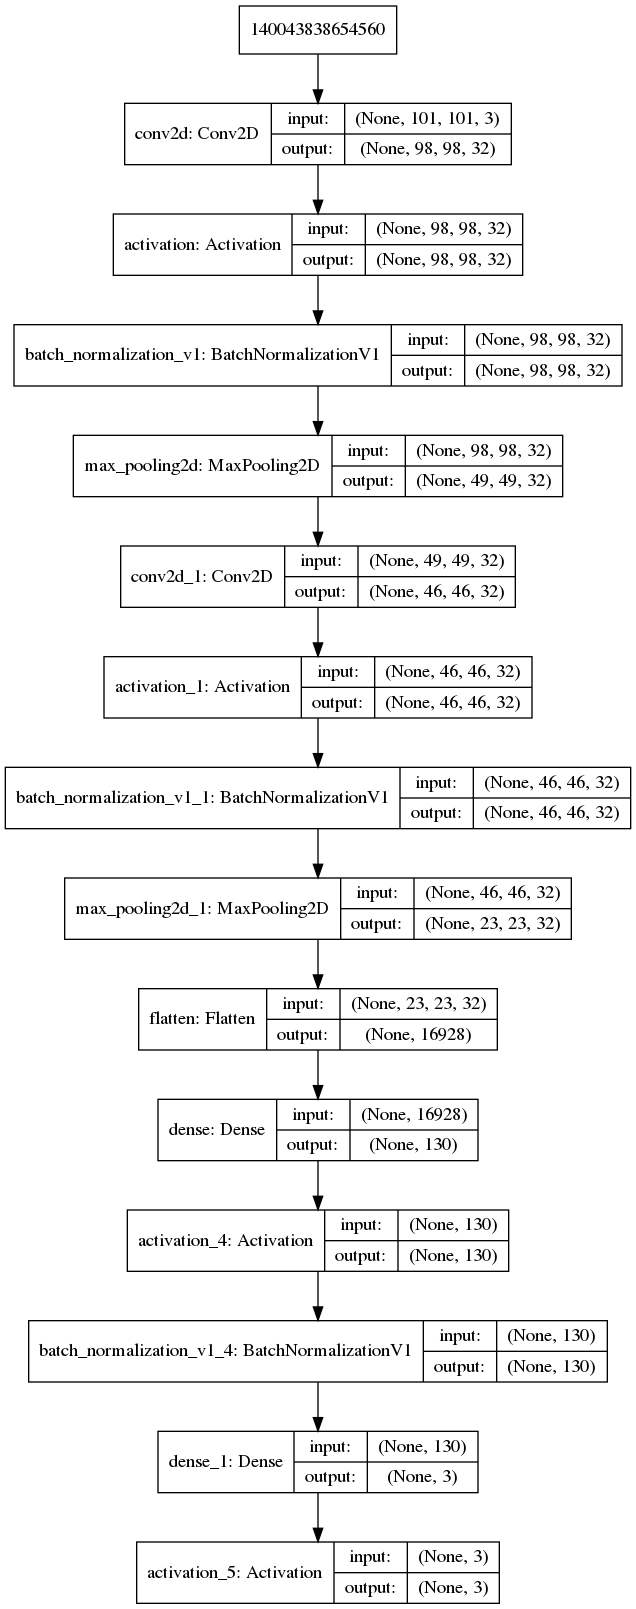

In [5]:
utils.plot_model(model, show_shapes = True, show_layer_names = True, to_file = 'plots/model.png')
Image(retina = True, filename = 'plots/model.png')

## Set up Training

Arguments for Training, that we need to set are:
* The path to the input dataset.
* The number of epochs to train for.
* Path for Our loss/accuracy plot, that will be output to disk
* etc.

In [6]:
MODEL_NAME = "corridor"
DATASET_PATH = os.getcwd() + "/dataset/corridor"
VALIDATION_PATH = DATASET_PATH + "/validation"
TRAIN_PATH = DATASET_PATH + "/train"
TRAIN_EVAL_PLOT_PATH = os.getcwd() + "/plots"


NUMBER_OF_EPOCHS = 300
BATCH_SIZE = 64
INIT_LEARNING_RATE = 1e-4
DECAY_LEARNING_RATE = 1e-4 / NUMBER_OF_EPOCHS

Here we can see the dataset structure:

+ dataset / corridor
    
    - validation
        - left (X Files)
        - forward (X Files)
        - right (X Files)
    - train
        - left (X Files)
        - forward (X Files)
        - right (X Files)

Initialize the set of labels from dataset we are going to train our network on.

In [7]:
LABELS = list(["left","forward","right"])

Genrate a list of image pathes for our training

In [8]:
train_image_paths = list(paths.list_images(TRAIN_PATH))
validation_image_paths = list(paths.list_images(VALIDATION_PATH))

print("Size of the train-dataset: " + str(len(train_image_paths)))
print("Size of the validation-dataset: " + str(len(validation_image_paths)))

Size of the train-dataset: 30914
Size of the test-dataset: 15305


Grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images

In [9]:
train_images = []
validation_images = []

train_labels = []
validation_labels = []
i = 0.0

for imagePath in train_image_paths:

    update_progress(i / len(train_image_paths), "Loading train images ")
    i = i + 1.0
    
    label = imagePath.split(os.path.sep)[-2]
 
    if label not in LABELS:
        continue
 
    image = cv2.imread(imagePath)
    #image = imutils.resize(img, width=1280)
    image = cv2.resize(image, (101, 101))
 
    train_images.append(image)
    train_labels.append(label)

In [10]:
i = 0.0
for imagePath in validation_image_paths:

    update_progress(i / len(validation_image_paths), "Loading validation images ")
    i = i + 1.0
    
    label = imagePath.split(os.path.sep)[-2]
 
    if label not in LABELS:
        continue
 
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (101, 101))
 
    validation_images.append(image)
    validation_labels.append(label)

Convert the data into a NumPy array, then preprocess it by scaling all pixel intensities to the range (0, 1)

In [11]:
train_images = np.array(train_images, dtype = "float") / 255.0
validation_images = np.array(validation_images, dtype = "float") / 255.0

Creating one-hot encoding vectors on the labels (for each image!)

In [12]:
left_hot_encoding = np.ndarray((3,),dtype=np.int64,strides=(8,))
forward_hot_encoding = np.ndarray((3,),dtype=np.int64,strides=(8,))
right_hot_encoding = np.ndarray((3,),dtype=np.int64,strides=(8,))

train_hot_encoding_vectors = []
validation_hot_encoding_vectors = []

left_hot_encoding[:] =    [1, 0, 0]
forward_hot_encoding[:] = [0, 1, 0]
right_hot_encoding[:] =   [0, 0, 1]

for label in train_labels:
    if(label == "left"):
        train_hot_encoding_vectors.append(left_hot_encoding)
    elif(label == "forward"):
        train_hot_encoding_vectors.append(forward_hot_encoding)
    elif(label == "right"):
        train_hot_encoding_vectors.append(right_hot_encoding)
        
for label in validation_labels:
    if(label == "left"):
        validation_hot_encoding_vectors.append(left_hot_encoding)
    elif(label == "forward"):
        validation_hot_encoding_vectors.append(forward_hot_encoding)
    elif(label == "right"):
        validation_hot_encoding_vectors.append(right_hot_encoding)

train_hot_encoding_vectors = np.asarray(train_hot_encoding_vectors)
validation_hot_encoding_vectors = np.asarray(validation_hot_encoding_vectors)

In [13]:
for i in range(len(LABELS)):
    index = train_labels.index(LABELS[i])
    print(str(LABELS[i]) + ":" + str(train_hot_encoding_vectors[index]))

#for i in range(len(LABELS)):
#    index = validation_labels.index(LABELS[i])
#    print(str(LABELS[i]) + ":" + str(validation_hot_encoding_vectors[index]))

left:[1 0 0]
forward:[0 1 0]
right:[0 0 1]
left:[1 0 0]
forward:[0 1 0]
right:[0 0 1]


Construct the training image generator for data augmentation

In [14]:
dataAugmentation = preprocessing.image.ImageDataGenerator(rotation_range = 15,
                                                          zoom_range = 0.10,
                                                          width_shift_range = 0.1,
                                                          height_shift_range = 0.1,
                                                          shear_range = 0.0,
                                                          horizontal_flip = False,
                                                          vertical_flip = False,
                                                          fill_mode="nearest")

Initialize Adam Optimizer

In [15]:
#sgdOptimizer = optimizers.SGD(lr=INIT_LEARNING_RATE, momentum=0.75, decay=DECAY_LEARNING_RATE, nesterov=True)
adamOptimizer = optimizers.Adam(lr = INIT_LEARNING_RATE, decay = DECAY_LEARNING_RATE)

After the model is constructed, configure its learning process by calling the compile method

In [16]:
model.compile(loss = "categorical_crossentropy", optimizer = adamOptimizer, metrics = ["accuracy"])

Save the entire model (HDF5 file) after every epoch (period).

In [17]:
checkpoint_saver = tf.keras.callbacks.ModelCheckpoint('./checkpoints/'+ MODEL_NAME +'_weights{epoch:08d}.h5',
                                save_weights_only=False,
                                period=1,
                                verbose=1,
                                save_best_only=False,
                                mode='auto')

## Training

Returns whether TensorFlow can access a Nvidia GPU with CUDA

In [18]:
tf.test.is_gpu_available(cuda_only = True)

True

Training the model on data generated batch-by-batch by a Python generator (or an instance of Sequence).
The generator is run in parallel to the model, for efficiency. For instance, this allows you to do real-time data augmentation on images on CPU in parallel to training your model on GPU.

In [19]:
start_time = time.time()

trainHistory = model.fit_generator(dataAugmentation.flow(train_images, train_hot_encoding_vectors, batch_size = BATCH_SIZE),
                                   validation_data = (validation_images, validation_hot_encoding_vectors),
                                   steps_per_epoch = len(train_images) // BATCH_SIZE,
                                   epochs = NUMBER_OF_EPOCHS,
                                   verbose = 2,
                                   callbacks = [checkpoint_saver])

end_time = time. time()

Epoch 1/300
15305/15305 [==============================] - 5s 349us/sample - loss: 0.1818 - acc: 0.9344

Epoch 00001: saving model to ./checkpoints/corridor_weights00000001.h5
 - 83s - loss: 0.2077 - acc: 0.9343 - val_loss: 0.1832 - val_acc: 0.9344
Epoch 2/300
15305/15305 [==============================] - 5s 329us/sample - loss: 0.0990 - acc: 0.9779

Epoch 00002: saving model to ./checkpoints/corridor_weights00000002.h5
 - 80s - loss: 0.1115 - acc: 0.9715 - val_loss: 0.0990 - val_acc: 0.9779
Epoch 3/300
15305/15305 [==============================] - 5s 329us/sample - loss: 0.1252 - acc: 0.9693

Epoch 00003: saving model to ./checkpoints/corridor_weights00000003.h5
 - 80s - loss: 0.0876 - acc: 0.9788 - val_loss: 0.1251 - val_acc: 0.9693
Epoch 4/300
15305/15305 [==============================] - 5s 338us/sample - loss: 0.1310 - acc: 0.9635

Epoch 00004: saving model to ./checkpoints/corridor_weights00000004.h5
 - 81s - loss: 0.0706 - acc: 0.9851 - val_loss: 0.1314 - val_acc: 0.9635
Epoc

Epoch 34/300
15305/15305 [==============================] - 5s 332us/sample - loss: 0.2216 - acc: 0.9244

Epoch 00034: saving model to ./checkpoints/corridor_weights00000034.h5
 - 79s - loss: 0.0262 - acc: 0.9961 - val_loss: 0.2209 - val_acc: 0.9244
Epoch 35/300
15305/15305 [==============================] - 5s 328us/sample - loss: 0.0410 - acc: 0.9882

Epoch 00035: saving model to ./checkpoints/corridor_weights00000035.h5
 - 79s - loss: 0.0283 - acc: 0.9951 - val_loss: 0.0410 - val_acc: 0.9882
Epoch 36/300
15305/15305 [==============================] - 5s 329us/sample - loss: 0.0691 - acc: 0.9780

Epoch 00036: saving model to ./checkpoints/corridor_weights00000036.h5
 - 80s - loss: 0.0242 - acc: 0.9966 - val_loss: 0.0690 - val_acc: 0.9780
Epoch 37/300
15305/15305 [==============================] - 5s 328us/sample - loss: 0.1453 - acc: 0.9518

Epoch 00037: saving model to ./checkpoints/corridor_weights00000037.h5
 - 80s - loss: 0.0266 - acc: 0.9957 - val_loss: 0.1450 - val_acc: 0.9518


Epoch 67/300
15305/15305 [==============================] - 5s 359us/sample - loss: 0.0698 - acc: 0.9772

Epoch 00067: saving model to ./checkpoints/corridor_weights00000067.h5
 - 80s - loss: 0.0254 - acc: 0.9969 - val_loss: 0.0701 - val_acc: 0.9772
Epoch 68/300
15305/15305 [==============================] - 5s 325us/sample - loss: 0.1719 - acc: 0.9425

Epoch 00068: saving model to ./checkpoints/corridor_weights00000068.h5
 - 79s - loss: 0.0193 - acc: 0.9972 - val_loss: 0.1726 - val_acc: 0.9425
Epoch 69/300
15305/15305 [==============================] - 5s 330us/sample - loss: 0.5239 - acc: 0.8580

Epoch 00069: saving model to ./checkpoints/corridor_weights00000069.h5
 - 81s - loss: 0.0335 - acc: 0.9932 - val_loss: 0.5308 - val_acc: 0.8580
Epoch 70/300
15305/15305 [==============================] - 5s 338us/sample - loss: 0.1655 - acc: 0.9516

Epoch 00070: saving model to ./checkpoints/corridor_weights00000070.h5
 - 81s - loss: 0.0263 - acc: 0.9947 - val_loss: 0.1694 - val_acc: 0.9516


Epoch 100/300
15305/15305 [==============================] - 5s 324us/sample - loss: 0.0762 - acc: 0.9750

Epoch 00100: saving model to ./checkpoints/corridor_weights00000100.h5
 - 80s - loss: 0.0221 - acc: 0.9974 - val_loss: 0.0769 - val_acc: 0.9750
Epoch 101/300
15305/15305 [==============================] - 5s 321us/sample - loss: 0.1363 - acc: 0.9657

Epoch 00101: saving model to ./checkpoints/corridor_weights00000101.h5
 - 79s - loss: 0.0181 - acc: 0.9967 - val_loss: 0.1365 - val_acc: 0.9657
Epoch 102/300
15305/15305 [==============================] - 5s 325us/sample - loss: 0.1426 - acc: 0.9497

Epoch 00102: saving model to ./checkpoints/corridor_weights00000102.h5
 - 79s - loss: 0.0205 - acc: 0.9975 - val_loss: 0.1426 - val_acc: 0.9497
Epoch 103/300
15305/15305 [==============================] - 5s 324us/sample - loss: 0.2137 - acc: 0.9365

Epoch 00103: saving model to ./checkpoints/corridor_weights00000103.h5
 - 80s - loss: 0.0169 - acc: 0.9975 - val_loss: 0.2139 - val_acc: 0.9

 - 82s - loss: 0.0168 - acc: 0.9972 - val_loss: 0.0617 - val_acc: 0.9820
Epoch 133/300
15305/15305 [==============================] - 5s 323us/sample - loss: 0.1134 - acc: 0.9715

Epoch 00133: saving model to ./checkpoints/corridor_weights00000133.h5
 - 80s - loss: 0.0191 - acc: 0.9979 - val_loss: 0.1157 - val_acc: 0.9715
Epoch 134/300
15305/15305 [==============================] - 5s 325us/sample - loss: 0.1070 - acc: 0.9669

Epoch 00134: saving model to ./checkpoints/corridor_weights00000134.h5
 - 80s - loss: 0.0193 - acc: 0.9966 - val_loss: 0.1081 - val_acc: 0.9669
Epoch 135/300
15305/15305 [==============================] - 5s 325us/sample - loss: 0.1011 - acc: 0.9660

Epoch 00135: saving model to ./checkpoints/corridor_weights00000135.h5
 - 81s - loss: 0.0142 - acc: 0.9979 - val_loss: 0.1022 - val_acc: 0.9660
Epoch 136/300
15305/15305 [==============================] - 5s 323us/sample - loss: 0.1006 - acc: 0.9633

Epoch 00136: saving model to ./checkpoints/corridor_weights00000136

 - 80s - loss: 0.0141 - acc: 0.9977 - val_loss: 0.0490 - val_acc: 0.9856
Epoch 198/300
15305/15305 [==============================] - 5s 334us/sample - loss: 0.0786 - acc: 0.9798

Epoch 00198: saving model to ./checkpoints/corridor_weights00000198.h5
 - 80s - loss: 0.0124 - acc: 0.9981 - val_loss: 0.0785 - val_acc: 0.9798
Epoch 199/300
15305/15305 [==============================] - 5s 333us/sample - loss: 0.1749 - acc: 0.9597

Epoch 00199: saving model to ./checkpoints/corridor_weights00000199.h5
 - 80s - loss: 0.0119 - acc: 0.9984 - val_loss: 0.1743 - val_acc: 0.9597
Epoch 200/300
15305/15305 [==============================] - 5s 333us/sample - loss: 0.1389 - acc: 0.9492

Epoch 00200: saving model to ./checkpoints/corridor_weights00000200.h5
 - 80s - loss: 0.0123 - acc: 0.9979 - val_loss: 0.1393 - val_acc: 0.9492
Epoch 201/300
15305/15305 [==============================] - 5s 330us/sample - loss: 0.1594 - acc: 0.9435

Epoch 00201: saving model to ./checkpoints/corridor_weights00000201

 - 81s - loss: 0.0103 - acc: 0.9990 - val_loss: 0.2015 - val_acc: 0.9506
Epoch 263/300
15305/15305 [==============================] - 5s 321us/sample - loss: 0.0746 - acc: 0.9763

Epoch 00263: saving model to ./checkpoints/corridor_weights00000263.h5
 - 80s - loss: 0.0097 - acc: 0.9989 - val_loss: 0.0743 - val_acc: 0.9763
Epoch 264/300
15305/15305 [==============================] - 5s 321us/sample - loss: 0.1391 - acc: 0.9530

Epoch 00264: saving model to ./checkpoints/corridor_weights00000264.h5
 - 81s - loss: 0.0108 - acc: 0.9984 - val_loss: 0.1408 - val_acc: 0.9530
Epoch 265/300
15305/15305 [==============================] - 5s 330us/sample - loss: 0.6555 - acc: 0.7943

Epoch 00265: saving model to ./checkpoints/corridor_weights00000265.h5
 - 81s - loss: 0.0124 - acc: 0.9980 - val_loss: 0.6556 - val_acc: 0.7943
Epoch 266/300
15305/15305 [==============================] - 5s 324us/sample - loss: 0.1101 - acc: 0.9712

Epoch 00266: saving model to ./checkpoints/corridor_weights00000266

In [20]:
needed_time_sec = end_time - start_time
hours = int(needed_time_sec/60/60)
minutes = int(needed_time_sec/60%60)
secondes = int(needed_time_sec%60)
print("Total training time: " + str(hours) + "[h] " + str(minutes) + "[min] " + str(secondes) + "[sec]")

Total training time: 6[h] 42[min] 41[sec]


A History.history attribute saves a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable).

## Evaluation
To evaluate our model, we’ll use the validation data and print a classification_report

In [21]:
predictions = model.predict(validation_images, batch_size = BATCH_SIZE)
print(classification_report(validation_hot_encoding_vectors.argmax(axis = 1),
                            predictions.argmax(axis = 1),
                            target_names = np.asarray(LABELS)))

              precision    recall  f1-score   support

        left       0.98      0.94      0.96      5123
     forward       0.98      0.96      0.97      5052
       right       0.93      0.99      0.96      5130

   micro avg       0.96      0.96      0.96     15305
   macro avg       0.96      0.96      0.96     15305
weighted avg       0.96      0.96      0.96     15305



Plot our accuracy/loss training history and save it to disk

Best val. Accuracy 0.9882391 at Epoch 35


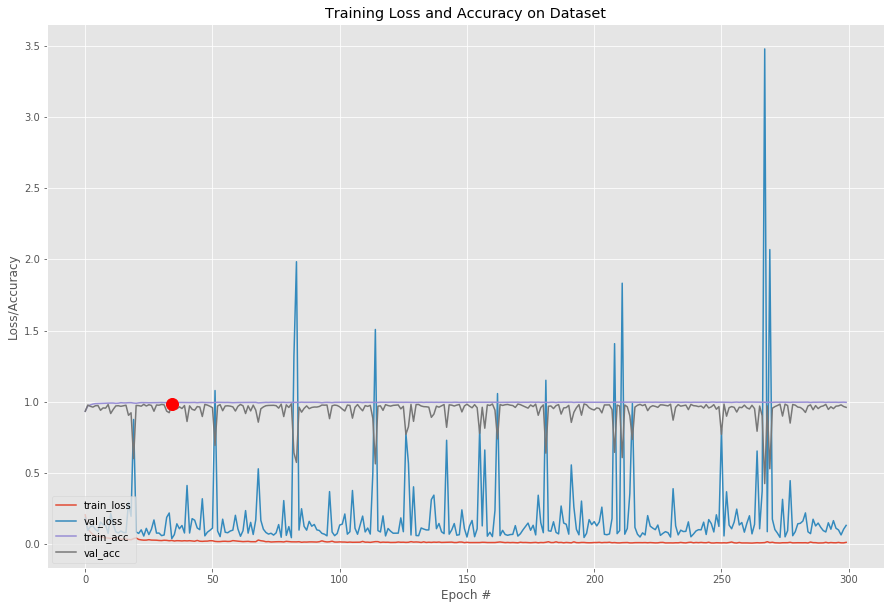

In [34]:
N = NUMBER_OF_EPOCHS
H = trainHistory
plt.style.use("ggplot")
plt.figure(figsize=(15,10))
plt.plot(np.arange(0, N), H.history["loss"], label = "train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label = "train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label = "val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc = "lower left")
plt.savefig(TRAIN_EVAL_PLOT_PATH + "/"+ MODEL_NAME +"_Loss_Accuracy.png")

ymax = max(H.history["val_acc"])
xpos = H.history["val_acc"].index(ymax)
print("Best val. Accuracy " + str(H.history["val_acc"][xpos]) + " at Epoch " + str(xpos+1))
plt.plot([xpos],[H.history["val_acc"][xpos]],"ro",markersize=12)
plt.show()

### Sources
- https://www.tensorflow.org/guide/keras
- http://rpg.ifi.uzh.ch/docs/RAL16_Giusti.pdf
- https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
- https://keras.io/models/sequential/